In [1]:
%load_ext autoreload
%autoreload 2
import random
from Environment import Environment
from CompanyAgent import CompanyAgent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm

# Helper functions

In [2]:
def generate_agents(
        count,
        expected_emission, 
        initial_allowance, 
        sell_price, 
        buy_price, 
        activate_abatement=True, 
        emission_rate_noise=0.01, 
        expected_emission_noise=0.1,
        advanced_trading=False):
    '''
    Generate a list of agents with random parameters.
    Args:
        count: Number of agents to generate
        expected_emission: A tuple of (min, max) expected emission
        initial_allowance: A tuple of (min, max) initial allowance
        sell_price: A tuple of (min, max) sell price
        buy_price: A tuple of (min, max) buy price
        activate_abatement: Whether the agent will use abatement
        emission_rate_noise: The noise for the emission rate
        expected_emission_noise: The noise for the expected emission
        advanced_trading: Whether the agent will use advanced trading
    Returns:
        A list of agents'''
    agents = []
    for i in range(count):
        agents.append(CompanyAgent(
            np.random.uniform(*expected_emission),
            np.random.uniform(*initial_allowance),
            np.random.uniform(*sell_price),
            np.random.uniform(*buy_price),
            activate_abatement=activate_abatement,
            emission_rate_noise=emission_rate_noise,
            expected_emission_noise=expected_emission_noise,
            advanced_trading=advanced_trading))
    return agents


In [3]:
def init_eu():
    '''
    Initialize the agents with the data from the EU ETS.
    '''
    df = pd.read_csv("./data/data_for_init_melted.csv")
    training_data = df[['year', 'INSTALLATION_NAME', 'ALLOCATION_', 'VERIFIED_EMISSIONS_']][df.year==2018].dropna()
    training_data = training_data[['ALLOCATION_', 'VERIFIED_EMISSIONS_']].to_numpy().tolist()

    agents = []
    for i in range(len(training_data)):
        agents.append(CompanyAgent(
            training_data[i][1],
            training_data[i][0],
            np.random.uniform(0, 100),
            np.random.uniform(0, 100),
            activate_abatement=True,
            emission_rate_noise=training_data[i][1]*np.random.uniform(0.001, 0.01)/365, # 0.1% to 1% of the emission rate
            expected_emission_noise=training_data[i][1]*0.1,
            advanced_trading=True
        ))
    expected_emissions = np.array(training_data)[:, 1].sum() - np.array(training_data)[:, 0].sum()
    agents.append(CompanyAgent(
        0,
        0.98*expected_emissions,
        0,
        100,
        0,
        0,
        False,
        False))

    return agents

In [4]:
def run_simulation(agents, steps=365, mode="seller_preferred"):
    '''
    Run the simulation for a number of steps/days.
    Args:
        agents: A list of agents
        steps: The number of days to run
    Returns:
    '''
    env = Environment(5, agents, mode=mode)

    print("start simulation")
    for i in tqdm.tqdm(range(365)):
        if i < 2:
            env.update(plot=True)
        else:
            env.update(plot=False)
    for agent in env.agents:
        env.track_agent_state(agent)

    trade_df = pd.DataFrame(env.trade_hist_dict)
    market_df = pd.DataFrame(env.market_hist_dict)
    agent_df = pd.DataFrame(env.agent_hist_dict)

    #join the two dataframes on days
    df = pd.merge(trade_df, market_df, how = "right", on="day")

    return df, agent_df

In [5]:
def plot_results(df, agent_df):
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    grid = True
    grid_alpha = 0.3

    # Plot 1: Lineplot for trade_price and market_price
    try:
        sns.lineplot(x="day", y="trade_price", data=df, ax=axes[0, 0])
        sns.lineplot(x="day", y="market_price", data=df, ax=axes[0, 0])
    except:
        print("No trades were made")
    axes[0, 0].legend(["trade_price", "95 perc CI","market_price"])
    axes[0, 0].title.set_text("Trade price and market price")
    axes[0, 0].grid(grid, alpha=grid_alpha)
    #xlabel ylable
    axes[0, 0].set_xlabel("Day")
    axes[0, 0].set_ylabel("Price [€ per Ton CO2]")

    # Plot 2: Lineplot for trade_price count
    df.groupby("day").sum().trade_amount.plot(kind="line", ax=axes[0, 1])
    axes[0, 1].legend(["trades"])
    axes[0, 1].title.set_text("Number of trades")
    axes[0, 1].grid(grid, alpha=grid_alpha)
    #xlabel ylable
    axes[0, 1].set_xlabel("Day")
    axes[0, 1].set_ylabel("Number of trades")

    # Plot 3: Lineplot for agent deficit
    agent_df.groupby("day").deficit.sum().plot(kind="line", ax=axes[1, 0], alpha=1)
    axes[1, 0].title.set_text("Expected total allowance deficit")
    #set ylim to 0 to 20000
    axes[1, 0].grid(grid, alpha=grid_alpha)
    #xlabel ylable
    axes[1, 0].set_xlabel("Day")
    axes[1, 0].set_ylabel("Deficit [Ton CO2]")

    # Plot 4: Lineplot for agent count separated by state
    state_counts = agent_df.groupby("day").state.value_counts().unstack(fill_value=0)
    try:
        state_counts['idle'].plot(kind="line", linestyle='-.',ax=axes[1, 1], alpha = 0.8, lw=2)  # Solid line for 'idle'
    except:
        print("No idles were made")
    try:
        state_counts['buy'].plot(kind="line", linestyle='--', ax=axes[1, 1], alpha = 0.8, lw=2)  # Dashed line for 'buy'
    except:
        print("No buys were made")
    try:
        state_counts['sell'].plot(kind="line", linestyle=':', ax=axes[1, 1], alpha = 0.8, lw=2)  # Dotted line for 'sell'
    except:
        print("No sells were made")

    axes[1, 1].legend(["Idle", "Buy", "Sell"])
    axes[1, 1].grid(grid, alpha=grid_alpha)
    axes[1, 1].title.set_text("Agent states")
    #xlabel ylable
    axes[1, 1].set_xlabel("Day")
    axes[1, 1].set_ylabel("Number of agents")


    # Adjust layout
    plt.tight_layout()
    # add time stamp at beginning
    import datetime
    now = datetime.datetime.now()
    # plt.savefig("plots/{}_{}.png".format(now.strftime("%Y-%m-%d_%H:%M:%S"), state), dpi=450)
    plt.show()

## 2. Experiments

In [6]:
seed_number = 41

## 2.1 Experiment 1: Idle agents

start simulation


100%|██████████| 365/365 [00:01<00:00, 336.01it/s]
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


No trades were made
No buys were made
No sells were made


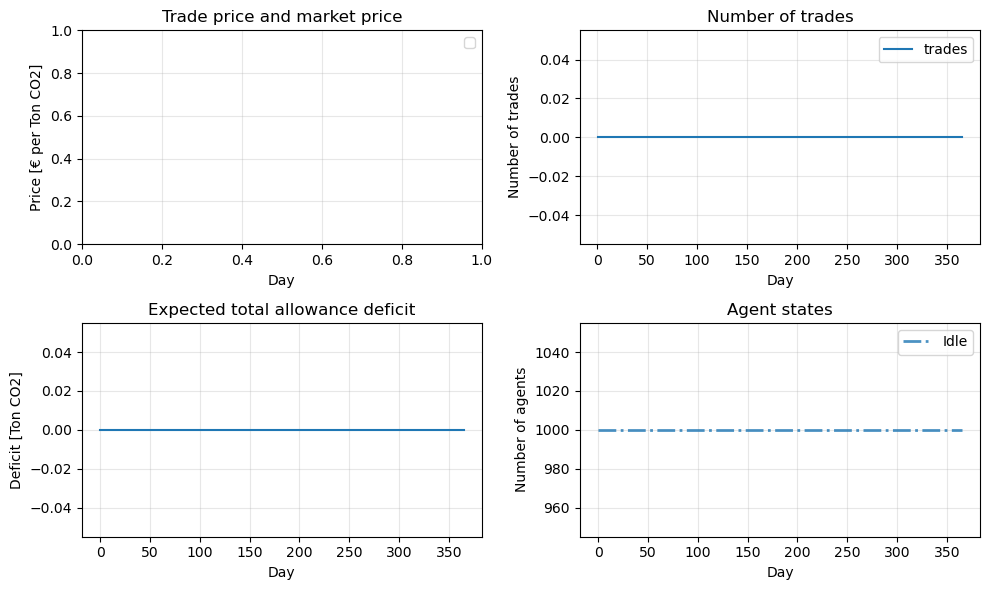

In [7]:
random.seed(seed_number)
np.random.seed(seed_number)

# base state, everyone has what he needs
agents = generate_agents(
    1000, 
    (10000,10000), 
    (10000,10000), 
    (0,0), 
    (100,100),
    activate_abatement=False, 
    emission_rate_noise=0, 
    expected_emission_noise=0)

df, agent_df = run_simulation(agents, steps=365, mode="seller_preferred")
plot_results(df, agent_df)

## 2.2 Experiment 2: Agents with simple trading strategies, no noise, saturation

start simulation


  0%|          | 0/365 [00:00<?, ?it/s]

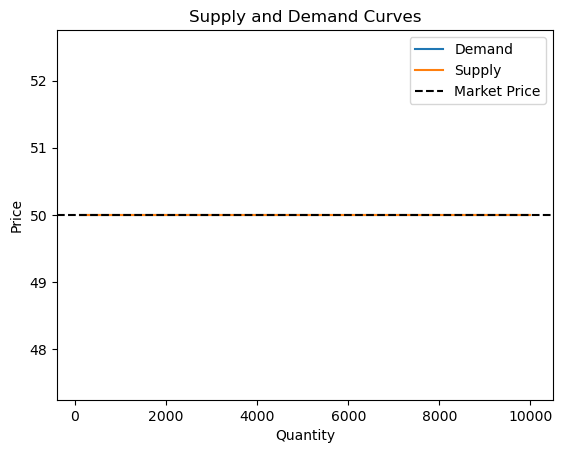

100%|██████████| 365/365 [00:00<00:00, 1521.45it/s]
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: F

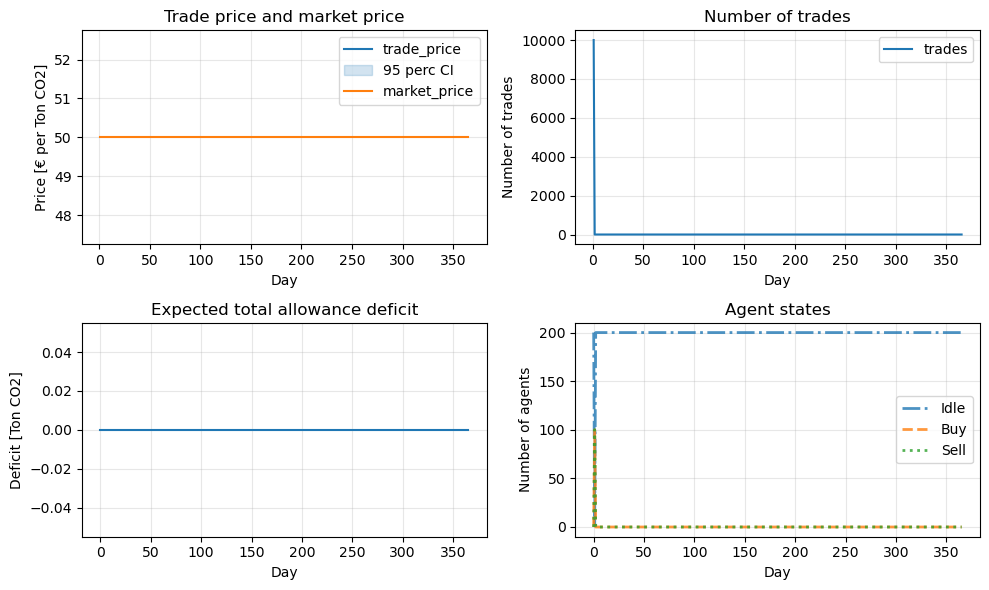

In [8]:
random.seed(seed_number)
np.random.seed(seed_number)
agents = []
selling_agents = generate_agents(
        100, 
        (10000,10000), 
        (10100, 10100), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0, 
        expected_emission_noise=0)
buying_agents = generate_agents(
    100, 
    (10000,10000), 
    (9900, 9900), 
    (0,0), 
    (100,100),
    activate_abatement=False, 
    emission_rate_noise=0, 
    expected_emission_noise=0)
agents += selling_agents
agents += buying_agents

df, agent_df = run_simulation(agents, steps=365, mode="seller_preferred")
plot_results(df, agent_df)

## 2.3 Experiment 3: Agents with simple trading strategies, deficit situation

start simulation


  0%|          | 0/365 [00:00<?, ?it/s]

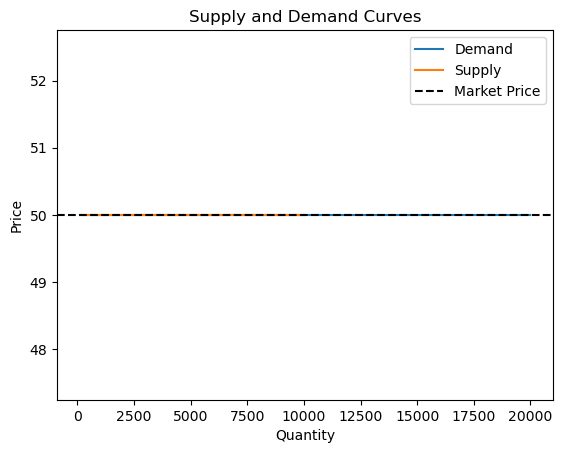

100%|██████████| 365/365 [00:00<00:00, 875.76it/s]
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: Fu

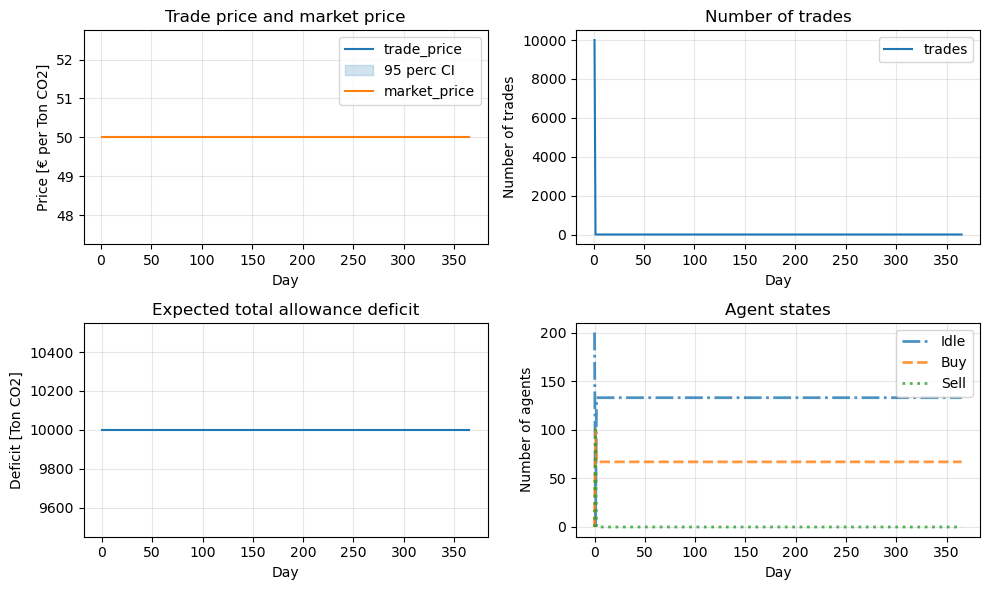

In [9]:
random.seed(seed_number)
np.random.seed(seed_number)
agents = []
selling_agents = generate_agents(
    100, 
    (10000,10000), 
    (10100, 10100), 
    (0,0), 
    (100,100),
    activate_abatement=False, 
    emission_rate_noise=0, 
    expected_emission_noise=0)
buying_agents = generate_agents(
    100, 
    (10000,10000), 
    (9800, 9800), 
    (0,0), 
    (100,100),
    activate_abatement=False, 
    emission_rate_noise=0, 
    expected_emission_noise=0)
agents += selling_agents
agents += buying_agents
df, agent_df = run_simulation(agents, steps=365, mode="seller_preferred")
plot_results(df, agent_df)

## 2.4 Experiment 4: Agents with simple trading strategies, deficit, with noise/randomness

start simulation


  0%|          | 0/365 [00:00<?, ?it/s]

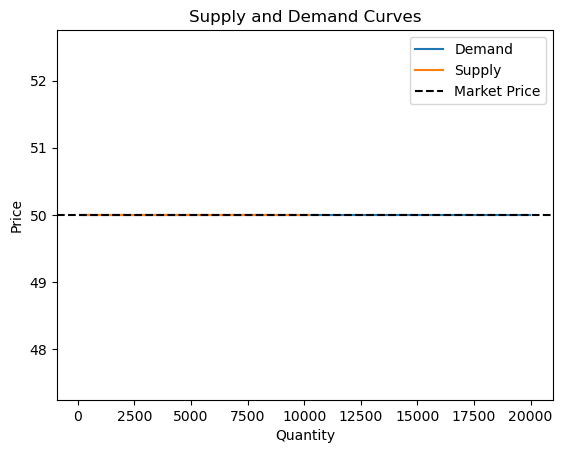

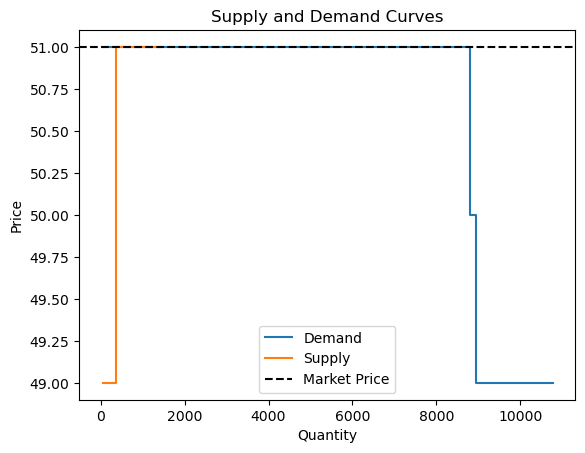

100%|██████████| 365/365 [00:01<00:00, 313.06it/s]
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: Fu

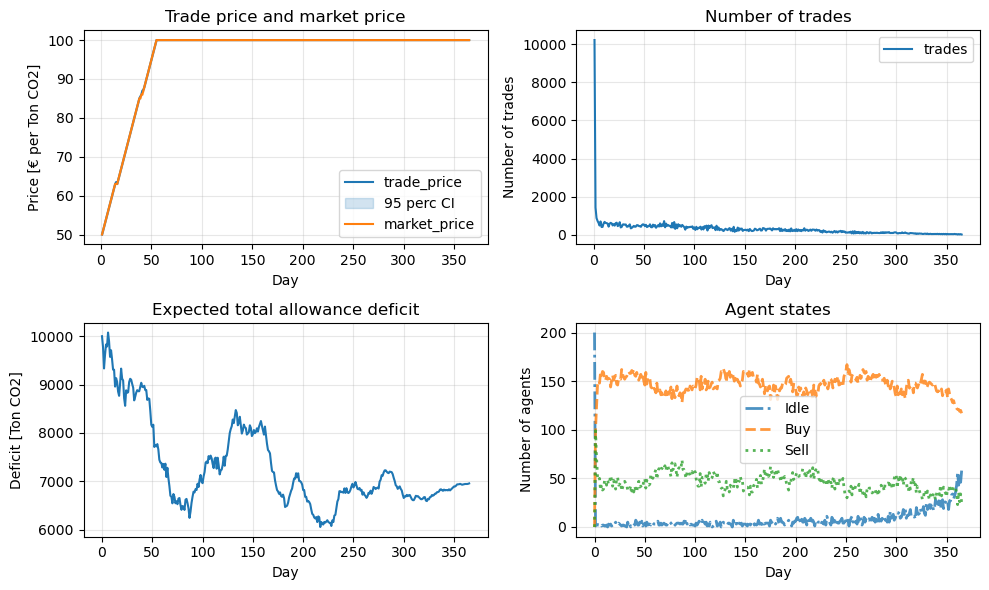

In [10]:
random.seed(seed_number)
np.random.seed(seed_number)
agents = []
selling_agents = generate_agents(
        100, 
        (10000,10000), 
        (10100, 10100), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1)
buying_agents = generate_agents(
        100, 
        (10000,10000), 
        (9800, 9800), 
        (0,0), 
        (100,100),
        activate_abatement=False, 
        emission_rate_noise=0.1, 
        expected_emission_noise=0.1)
agents += selling_agents
agents += buying_agents

df, agent_df = run_simulation(agents, steps=365, mode="seller_preferred")
plot_results(df, agent_df)

## 2.5 Experiment 5: Agents with advanced trading strategies, deficit, with noise/randomness

start simulation


  0%|          | 0/365 [00:00<?, ?it/s]

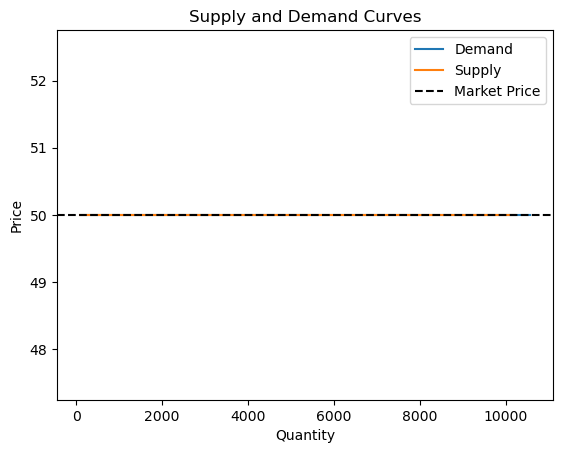

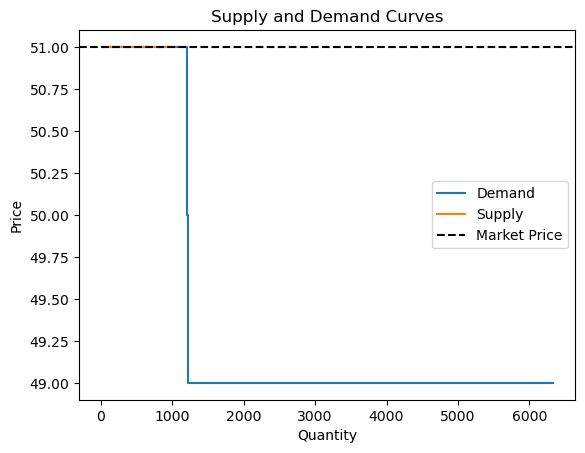

100%|██████████| 365/365 [00:01<00:00, 358.26it/s]
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: Fu

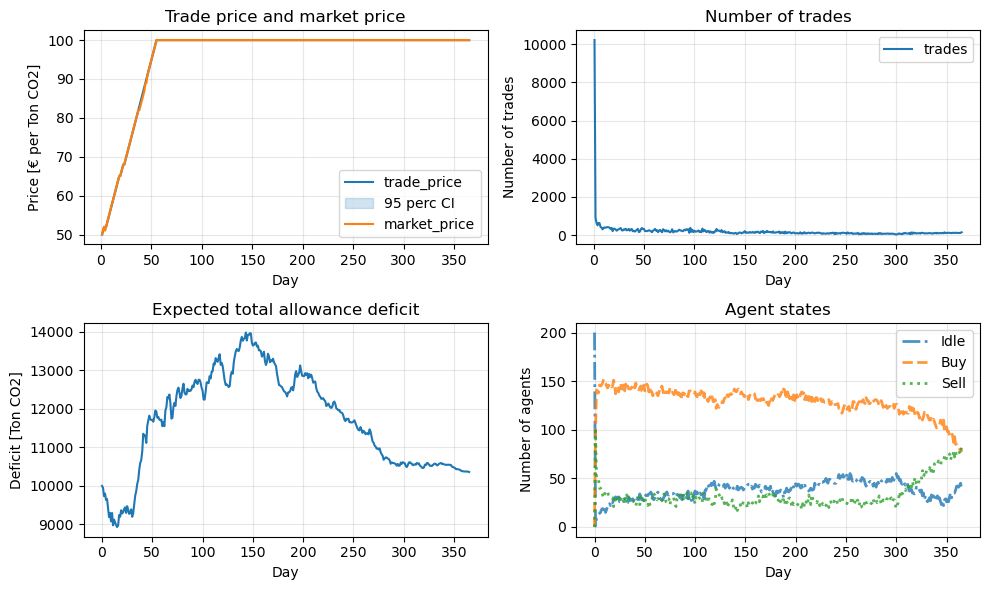

In [11]:
np.random.seed(seed_number)
random.seed(seed_number)
agents = []
selling_agents = generate_agents(
    100, 
    (10000,10000), 
    (10100, 10100), 
    (0,0), 
    (100,100),
    activate_abatement=False, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1)
buying_agents = generate_agents(
    100, 
    (10000,10000), 
    (9800, 9800), 
    (0,0), 
    (100,100),
    activate_abatement=False, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1,
    advanced_trading=True)
agents += selling_agents
agents += buying_agents

df, agent_df = run_simulation(agents, steps=365, mode="seller_preferred")
plot_results(df, agent_df)

## 2.6 Experiment 6: Agents with advanced trading strategies, deficit, with noise/randomness, with abatement

start simulation


  0%|          | 0/365 [00:00<?, ?it/s]

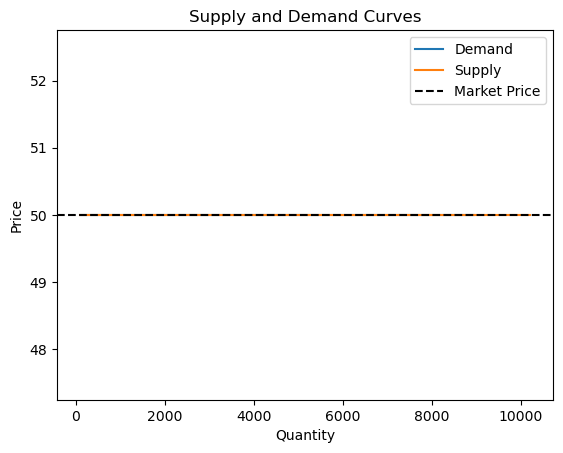

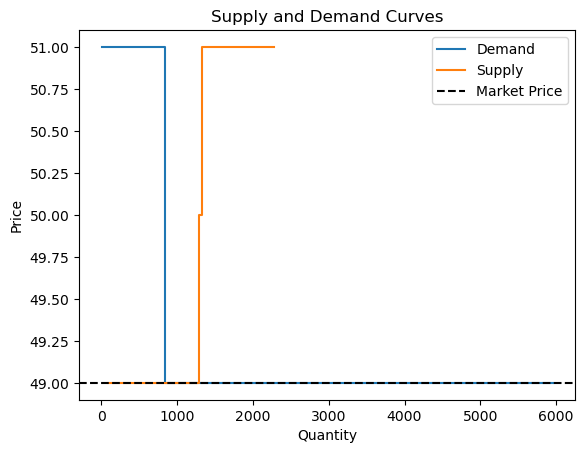

100%|██████████| 365/365 [00:00<00:00, 551.30it/s]
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: Fu

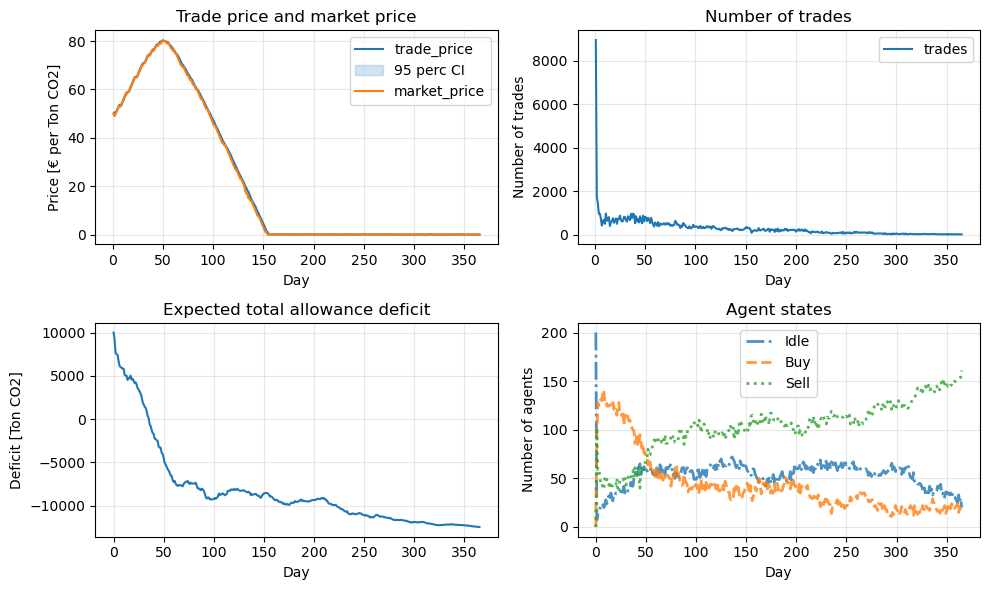

In [12]:
np.random.seed(seed_number)
random.seed(seed_number)
agents = []
selling_agents = generate_agents(
    100, 
    (10000,10000), 
    (10100, 10100), 
    (0,0), 
    (100,100),
    activate_abatement=True, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1)
buying_agents = generate_agents(
    100, 
    (10000,10000), 
    (9800, 9800), 
    (0,0), 
    (100,100),
    activate_abatement=True, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1,
    advanced_trading=True)
agents += selling_agents
agents += buying_agents

df, agent_df = run_simulation(agents, steps=365, mode="seller_preferred")
plot_results(df, agent_df)

## 2.7 Experiment 7: Agents with simple trading strategies, oversaturation, with noise/randomness

start simulation


  0%|          | 0/365 [00:00<?, ?it/s]

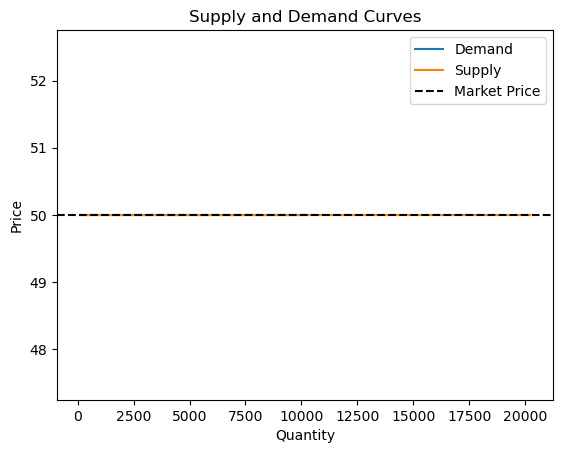

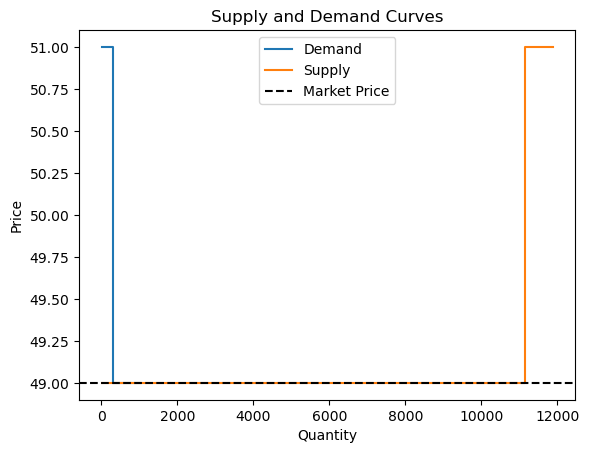

100%|██████████| 365/365 [00:00<00:00, 684.24it/s]
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: Fu

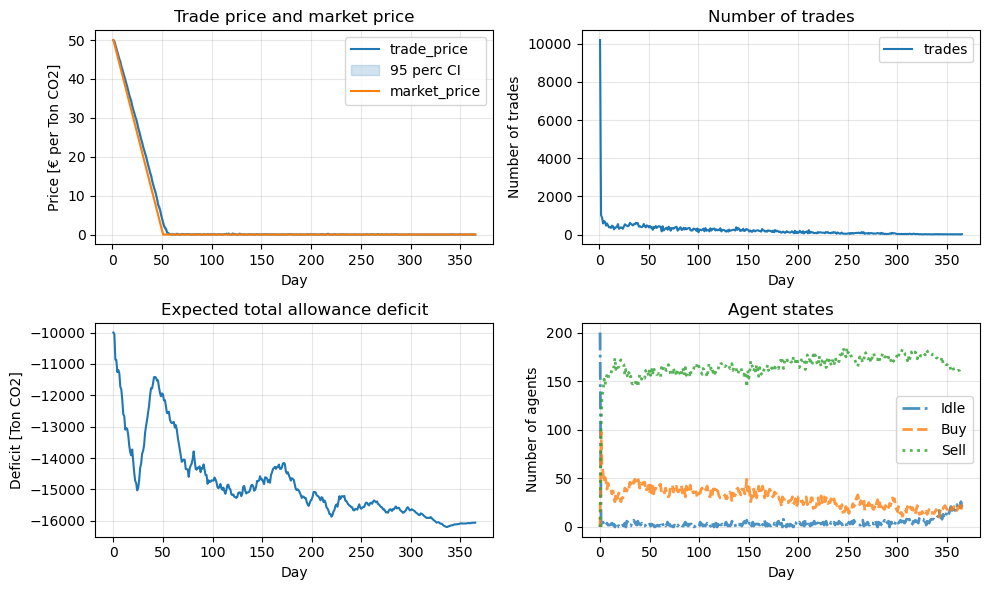

In [13]:
np.random.seed(seed_number)
random.seed(seed_number)
agents = []

selling_agents = generate_agents(
    100, 
    (10000,10000), 
    (10200, 10200), 
    (0,0), 
    (100,100),
    activate_abatement=False, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1)
buying_agents = generate_agents(
    100, 
    (10000,10000), 
    (9900, 9900), 
    (0,0), 
    (100,100),
    activate_abatement=False, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1)
agents += selling_agents
agents += buying_agents

df, agent_df = run_simulation(agents, steps=365, mode="seller_preferred")
plot_results(df, agent_df)

## 2.8 Experiment 8: Agents with simple trading strategies, deficit, different min sell and max buy prices, noise/randomness, with abatement

start simulation


  0%|          | 0/365 [00:00<?, ?it/s]

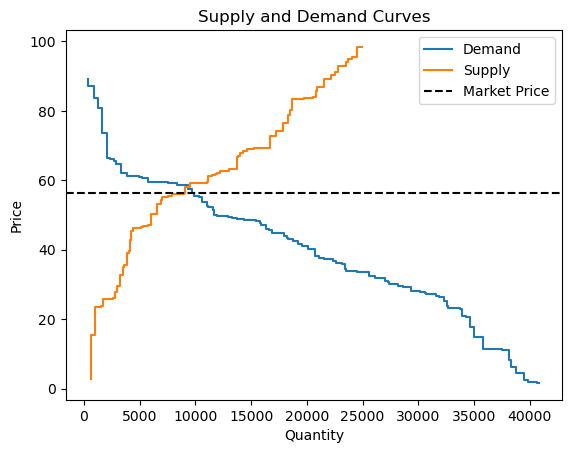

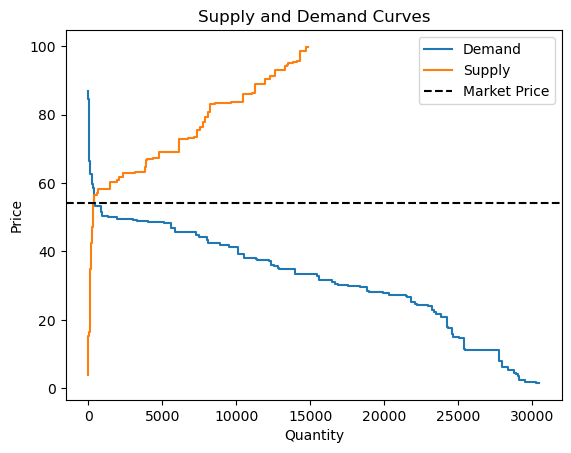

100%|██████████| 365/365 [00:00<00:00, 1018.92it/s]
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: F

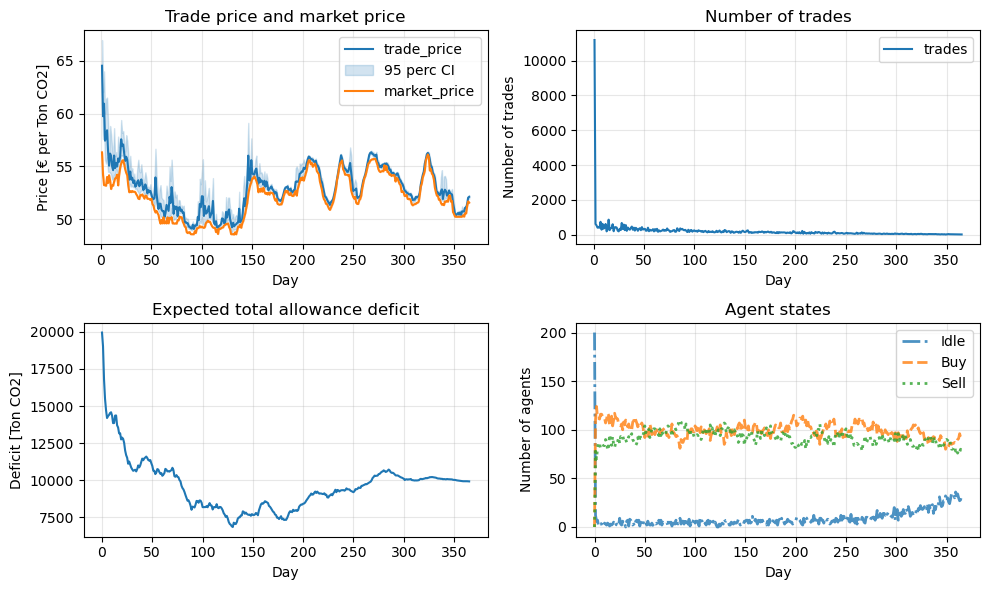

In [14]:
np.random.seed(seed_number)
random.seed(seed_number)
agents = []

selling_agents = generate_agents(
    100, 
    (10000,11000), 
    (10100, 11100), 
    (0,100), 
    (0,100),
    activate_abatement=True, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1,
    advanced_trading=False)
buying_agents = generate_agents(
    100, 
    (10000,11000), 
    (9800, 10800), 
    (0,100), 
    (0,100),
    activate_abatement=True, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1,
    advanced_trading=False)
agents += selling_agents
agents += buying_agents

df, agent_df = run_simulation(agents, steps=365, mode="seller_preferred")
plot_results(df, agent_df)

## 2.9 Experiment 9: Agents with advanced trading strategies, deficit, different min sell and max buy prices, noise/randomness, with abatement

start simulation


  0%|          | 0/365 [00:00<?, ?it/s]

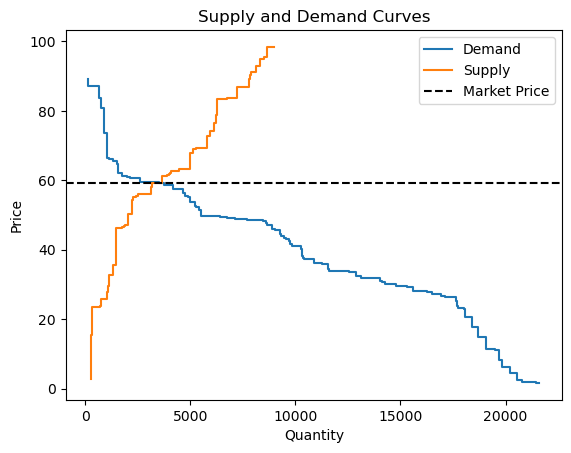

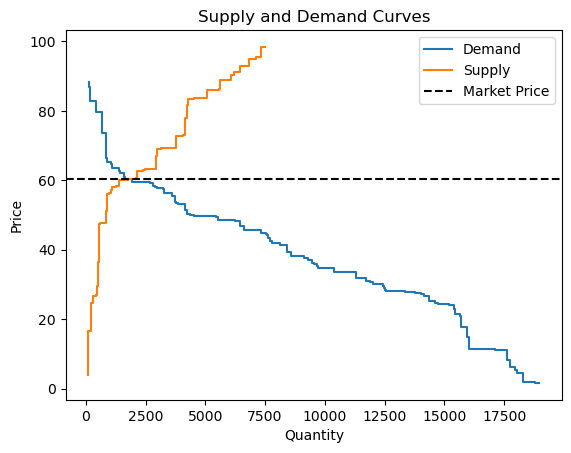

100%|██████████| 365/365 [00:00<00:00, 858.80it/s]
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: Fu

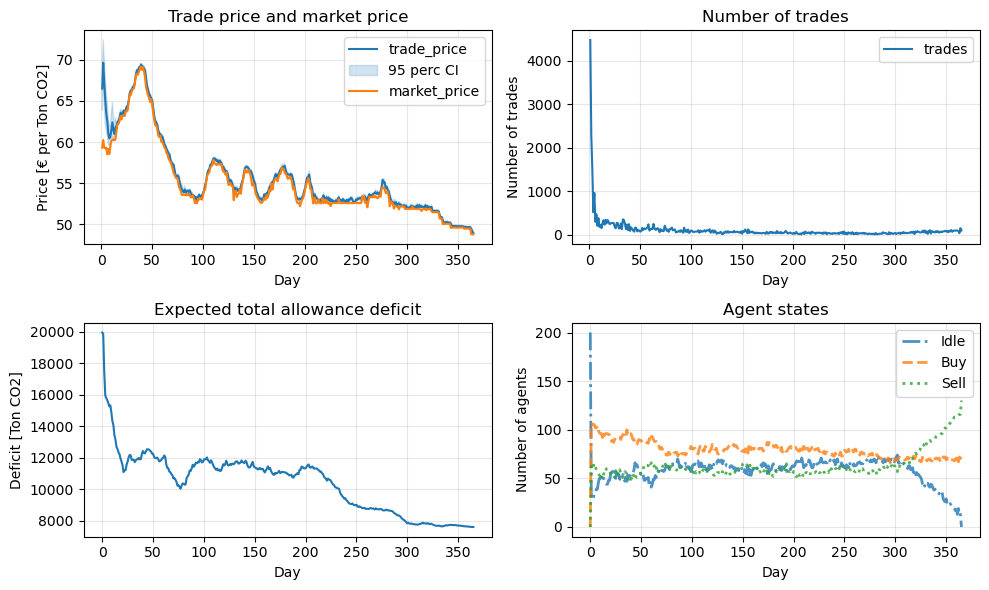

In [15]:
np.random.seed(seed_number)
random.seed(seed_number)
agents = []

selling_agents = generate_agents(
    100, 
    (10000,11000), 
    (10100, 11100), 
    (0,100), 
    (0,100),
    activate_abatement=True, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1,
    advanced_trading=True)
buying_agents = generate_agents(
    100, 
    (10000,11000), 
    (9800, 10800), 
    (0,100), 
    (0,100),
    activate_abatement=True, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1,
    advanced_trading=True)
agents += selling_agents
agents += buying_agents

df, agent_df = run_simulation(agents, steps=365, mode="seller_preferred")
plot_results(df, agent_df)

start simulation


  0%|          | 0/365 [00:00<?, ?it/s]

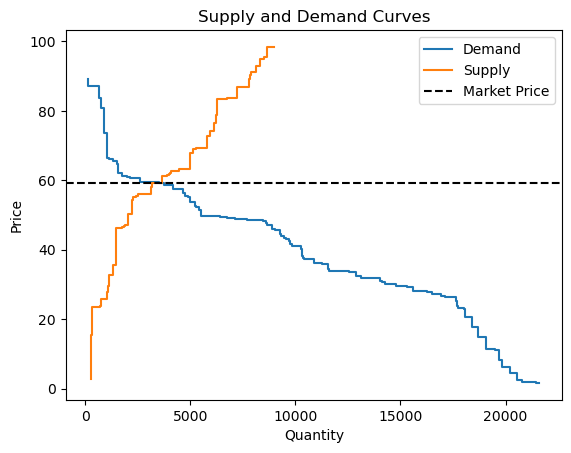

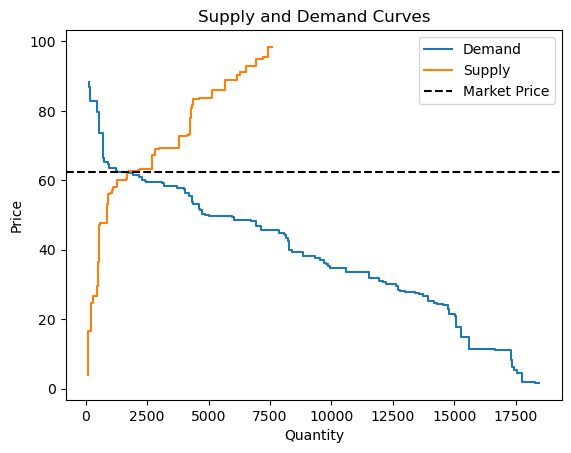

100%|██████████| 365/365 [00:00<00:00, 829.00it/s]
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: Fu

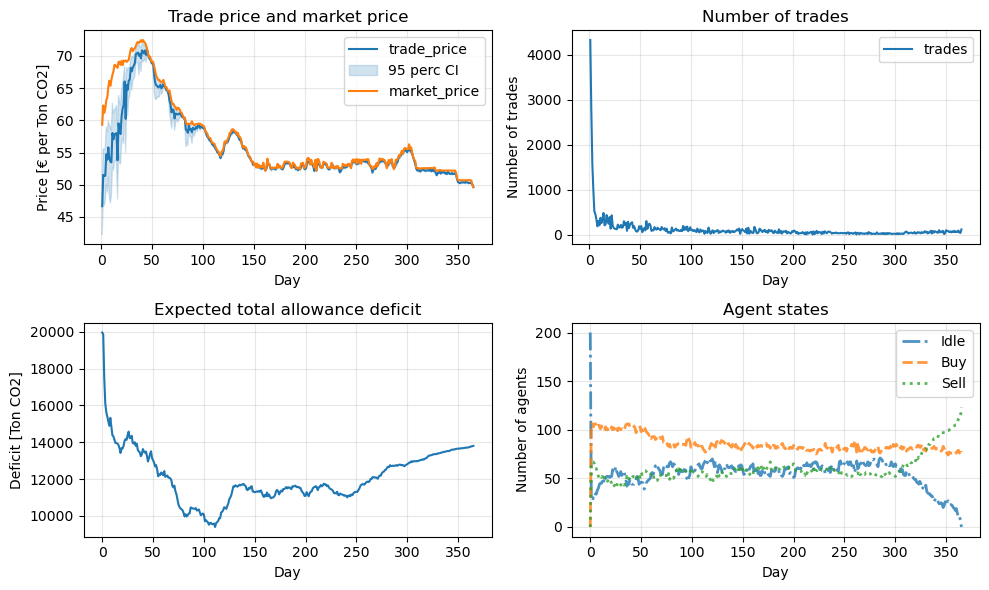

In [17]:
np.random.seed(seed_number)
random.seed(seed_number)
agents = []

selling_agents = generate_agents(
    100, 
    (10000,11000), 
    (10100, 11100), 
    (0,100), 
    (0,100),
    activate_abatement=True, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1,
    advanced_trading=True)
buying_agents = generate_agents(
    100, 
    (10000,11000), 
    (9800, 10800), 
    (0,100), 
    (0,100),
    activate_abatement=True, 
    emission_rate_noise=0.1, 
    expected_emission_noise=0.1,
    advanced_trading=True)
agents += selling_agents
agents += buying_agents

df, agent_df = run_simulation(agents, steps=365, mode="buyer_preferred")
plot_results(df, agent_df)

## 2.10 Experiment 10: EU data, agents with advanced trading strategies, different min sell and max buy prices, noise/randomness, with abatement

start simulation


  0%|          | 0/365 [00:00<?, ?it/s]

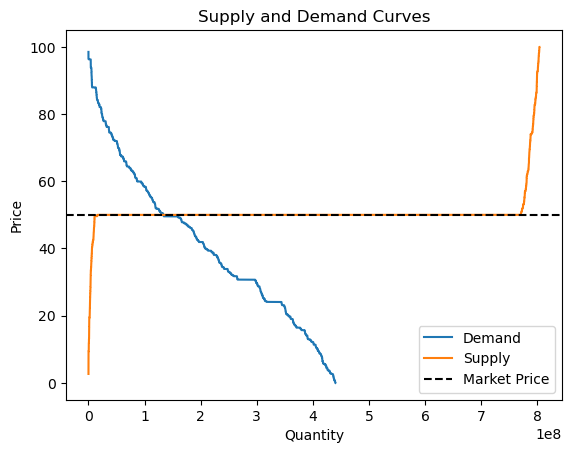

  0%|          | 1/365 [00:00<01:20,  4.53it/s]

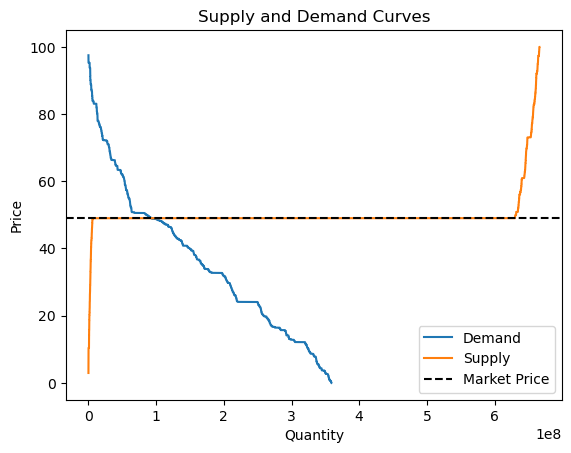

100%|██████████| 365/365 [00:52<00:00,  7.01it/s]
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lexi/miniconda3/envs/modsim/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: Fut

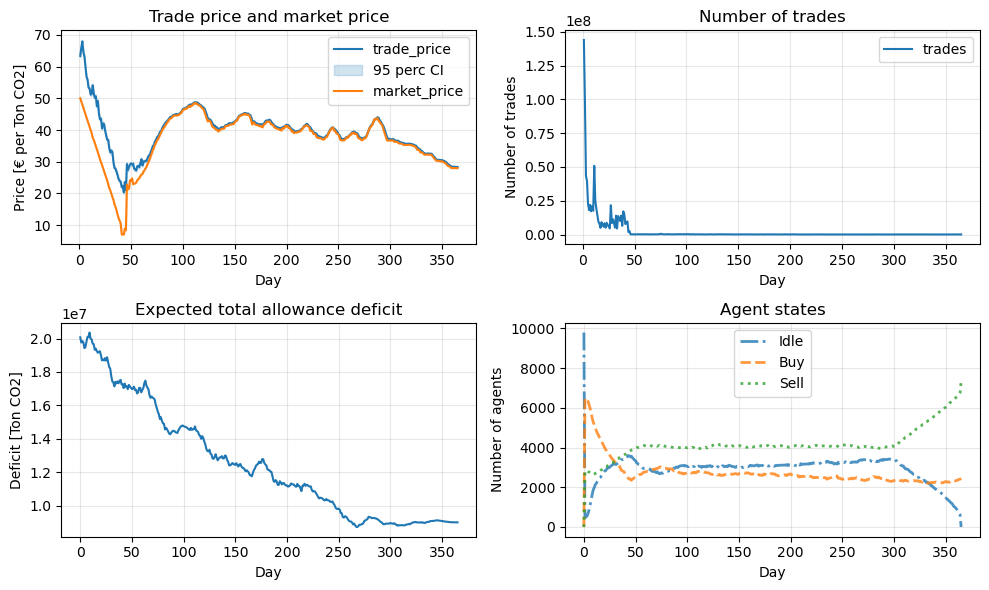

In [16]:
np.random.seed(seed_number)
random.seed(seed_number)
agents = init_eu()

df, agent_df = run_simulation(agents, steps=365, mode="seller_preferred")
plot_results(df, agent_df)